In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline
plt.show(block=True)

In [2]:
import datetime
from datetime import timedelta
forecast_out = 365 #Days from now

stock_ticker ='AMZN'

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(400)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)

In [3]:
stock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-29,1792.859985,1776.630005,1786.579956,1780.750000,3320800,1780.750000
2019-04-01,1815.670044,1798.729980,1800.109985,1814.189941,4238800,1814.189941
2019-04-02,1820.000000,1805.119995,1811.020020,1813.979980,3448100,1813.979980
2019-04-03,1830.000000,1809.619995,1826.719971,1820.699951,3980600,1820.699951
2019-04-04,1828.750000,1804.199951,1820.650024,1818.859985,3623900,1818.859985
...,...,...,...,...,...,...
2020-04-27,2444.879883,2363.000000,2443.199951,2376.000000,5645600,2376.000000
2020-04-28,2373.500000,2306.000000,2372.100098,2314.080078,5269400,2314.080078
2020-04-29,2391.889893,2310.000000,2330.010010,2372.709961,4591600,2372.709961


In [4]:
test_size=20
test_index = len(stock['Adj Close'])- test_size

In [5]:
train = stock['Adj Close'].iloc[:test_index]
test= stock['Adj Close'].iloc[test_index:]


In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler=MinMaxScaler()

In [8]:
scaler.fit(train.to_frame())

MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
scaled_train = scaler.transform(train.to_frame())

In [10]:
scaled_test = scaler.transform(test.to_frame())

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
len(test)

20

In [13]:
length=19
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [14]:
from tensorflow.keras.models import Sequential

In [15]:
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [16]:
n_features =1

In [17]:
model= Sequential()
# model.add(LSTM(150, activation='relu',return_sequences=True, input_shape=(length, n_features)))
# model.add(LSTM(150, activation='relu',return_sequences=True))
# model.add(LSTM(150, activation='relu',return_sequences=True))
model.add(LSTM(50, return_sequences=True, input_shape=(length, n_features)))
Dropout(0.2)
model.add(LSTM(50, return_sequences=True))
Dropout(0.2)
model.add(LSTM(50, return_sequences=True))
Dropout(0.2)
model.add(LSTM(50, return_sequences=True))
Dropout(0.2)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 19, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 19, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 19, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 19, 50)            20200     
_________________________________________________________________
dense (Dense)                (None, 19, 1)             51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [21]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [22]:
# model.fit_generator(generator, epochs=100,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=2,
                   validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 237 steps, validate for 1 steps
Epoch 1/2
237/237 [==============================] - 18s 74ms/step - loss: 0.0515 - val_loss: 0.3871
Epoch 2/2
237/237 [==============================] - 7s 29ms/step - loss: 0.0404 - val_loss: 0.6252


In [23]:
import tensorflow as tf
tf.keras.backend.clear_session()

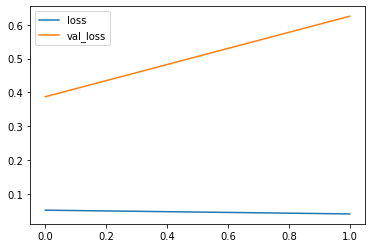

In [24]:
losses= pd.DataFrame(model.history.history)
losses.plot()

In [25]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [26]:
true_predictions =scaler.inverse_transform(test_predictions)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [27]:
predictions = pd.DataFrame(test)
# predictions['Test set'] = test.to_frame()

In [28]:
# test['Predictions'] = true_predictions
predictions['Predictions'] = true_predictions

NameError: name 'true_predictions' is not defined

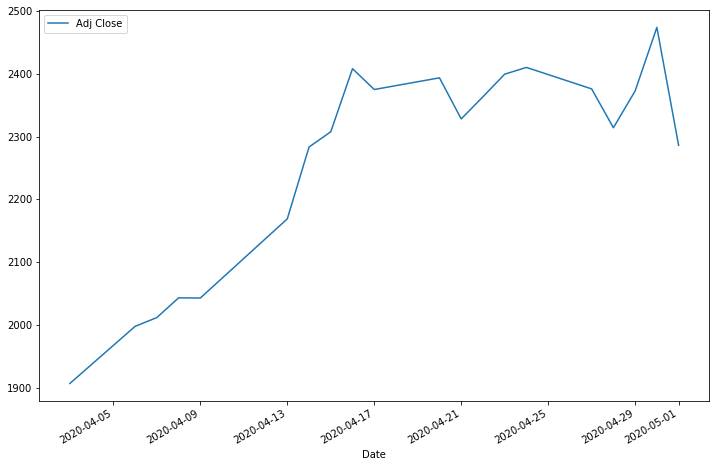

In [29]:
predictions.plot(figsize=(12,8))